# 목차
Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

Step 2. 디코더의 문장에 시작 토큰과 종료 토큰

Step 3. 케라스의 토크나이저로 텍스트를 숫자로

Step 4. 임베딩 층(Embedding layer) 사용

Step 5. 모델 구현하기

Step 6. 모델 평가하기

회고


# Step 0. Library Import

In [49]:
import tensorflow

print(tensorflow.__version__)

2.8.2
2.8.2


In [50]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

Read data

* 학습과 테스트 시의 원활한 진행을 위해서 데이터에서 상위 33,000개의 샘플만 사용해주세요.

* 33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [51]:
import os
file_path = '/content/drive/MyDrive/Aiffel_data/Exp10_NLP3/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 194513


eng  \
63341                  I just want to be clear.   
137571      Can you read that sign ahead of us?   
125790         Would you like something to eat?   
156642  I think Tom wants to sell us something.   
128335        I never had to worry about money.   

                                                      fra  \
63341            Je veux être clair, un point c'est tout.   
137571  Arrivez-vous à lire cette indication au-dessus...   
125790                     Veux-tu manger quelque chose ?   
156642   Je pense que Tom veut nous vendre quelque chose.   
128335      Je n'ai jamais eu à m'en faire pour l'argent.   

                                                       cc  
63341   CC-BY 2.0 (France) Attribution: tatoeba.org #2...  
137571  CC-BY 2.0 (France) Attribution: tatoeba.org #2...  
125790  CC-BY 2.0 (France) Attribution: tatoeba.org #1...  
156642  CC-BY 2.0 (France) Attribution: tatoeba.org #2...  
128335  CC-BY 2.0 (France) Attribution: tatoeba.org #2...

전체 샘플의 수 : 194513


eng  \
194242  I can't change the direction of the wind, but ...   
172203      Can you believe it? He's even lazier than me.   
98427                        Why do you put up with that?   
94939                        I'd rather not discuss that.   
26414                                  Tom is illiterate.   

                                                      fra  \
194242  Je ne peux pas changer la direction du vent, m...   
172203  Pouvez-vous le croire ? Il est encore plus fai...   
98427                      Pourquoi supportez-vous cela ?   
94939             Je préférerais ne pas discuter de cela.   
26414                                Tom est analphabète.   

                                                       cc  
194242  CC-BY 2.0 (France) Attribution: tatoeba.org #1...  
172203  CC-BY 2.0 (France) Attribution: tatoeba.org #1...  
98427   CC-BY 2.0 (France) Attribution: tatoeba.org #1...  
94939   CC-BY 2.0 (France) Attribution: tatoeba.org #2...  
26414   CC-BY 2.0 (France) Attribution: tatoeba.org #2...

In [52]:
lines = lines[['eng', 'fra']][:33000] # 3.3만개 샘플 사용
lines.sample(5)

eng                             fra
21431   We're all single.  Nous sommes tous célibataires.
17271   Are you finished?             Avez-vous terminé ?
26309  Tom didn't flinch.            Tom n’a pas bronché.
18491   I go to the park.                Je vais au parc.
9743      Do as you like.       Faites comme vous voulez.

eng                                                fra
7939      It has a leak.                                           Il fuit.
4736       He's in pain.                                        Il souffre.
4000        Tom shot me.                               Tom m'a tiré dessus.
19599  It's balmy today.  C'est réconfortant d'avoir un temps radieux au...
3969        Tom is tall.                                     Tom est grand.

In [53]:
lines.eng[:5]

0    Go.
1    Go.
2    Go.
3    Hi.
4    Hi.
Name: eng, dtype: object

0    Go.
1    Go.
2    Go.
3    Hi.
4    Hi.
Name: eng, dtype: object

In [54]:
lines.fra[:5]

0       Va !
1    Marche.
2    Bouge !
3    Salut !
4     Salut.
Name: fra, dtype: object

0       Va !
1    Marche.
2    Bouge !
3    Salut !
4     Salut.
Name: fra, dtype: object

#Step 1. 정제, 정규화, 전처리

* 1. 구두점(Punctuation)- 단어와 분리

* 2. 소문자 변환

In [55]:
# 데이터 전처리 함수
import re
def preprocess_sentence(lines):

    lines = re.sub(r"([?.!,¿])", r" \1 ", lines)  # 구두점 단어와 분리
    lines = lines.lower() # 텍스트 소문자화
    lines = lines.strip()

    return lines

In [56]:
clean_eng = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in lines['eng']:
    clean_eng.append(preprocess_sentence(s))

# 전처리 후 출력
print("english 전처리 후 결과: ", clean_eng[:5])

english 전처리 후 결과:  ['go .', 'go .', 'go .', 'hi .', 'hi .']
english 전처리 후 결과:  ['go .', 'go .', 'go .', 'hi .', 'hi .']


In [57]:
clean_fra = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in lines['fra']:
    clean_fra.append(preprocess_sentence(s))

print("france 전처리 후 결과: ", clean_fra[:5])

france 전처리 후 결과:  ['va  !', 'marche .', 'bouge  !', 'salut  !', 'salut .']
france 전처리 후 결과:  ['va  !', 'marche .', 'bouge  !', 'salut  !', 'salut .']


In [58]:
lines['eng'] = clean_eng
lines['fra'] = clean_fra

# 빈 값을 Null 값으로 변환
lines.replace('', np.nan, inplace=True)
print('=3')

=3
=3


* 3. 띄어쓰기 단위로 토큰화

In [59]:
temp_eng = []
for i in lines['eng']:
  temp_eng.append(i.split())


print(temp_eng)

[['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['run', '.'], ['who', '?'], ['wow', '!'], ['wow', '!'], ['wow', '!'], ['duck', '!'], ['duck', '!'], ['duck', '!'], ['fire', '!'], ['help', '!'], ['hide', '.'], ['hide', '.'], ['jump', '!'], ['jump', '.'], ['stop', '!'], ['stop', '!'], ['stop', '!'], ['wait', '!'], ['wait', '!'], ['wait', '!'], ['wait', '.'], ['wait', '.'], ['wait', '.'], ['wait', '.'], ['begin', '.'], ['begin', '.'], ['go', 'on', '.'], ['go', 'on', '.'], ['go', 'on', '.'], ['hello', '!'], ['hello', '!'], ['i', 'see', '.'], ['i', 'see', '.'], ['i', 'try', '.'], ['i', 'won', '!'], ['i', 'won', '!'], ['i', 'won', '.'], ['oh', 'no', '!'], ['relax', '.'], ['relax', '.'], ['relax', '.'], ['relax', '.'], ['relax', '.'], ['relax', '.'], ['relax', '.'], ['r

In [60]:
temp_fra = []
for i in lines['fra']:
  temp_fra.append(i.split())


print(temp_fra)

[['va', '!'], ['marche', '.'], ['bouge', '!'], ['salut', '!'], ['salut', '.'], ['cours', '!'], ['courez', '!'], ['prenez', 'vos', 'jambes', 'à', 'vos', 'cous', '!'], ['file', '!'], ['filez', '!'], ['cours', '!'], ['fuyez', '!'], ['fuyons', '!'], ['cours', '!'], ['courez', '!'], ['prenez', 'vos', 'jambes', 'à', 'vos', 'cous', '!'], ['file', '!'], ['filez', '!'], ['cours', '!'], ['fuyez', '!'], ['fuyons', '!'], ['qui', '?'], ['ça', 'alors', '!'], ['waouh', '!'], ['wah', '!'], ['à', 'terre', '!'], ['baisse-toi', '!'], ['baissez-vous', '!'], ['au', 'feu', '!'], ['à', "l'aide", '!'], ['cache-toi', '.'], ['cachez-vous', '.'], ['saute', '.'], ['saute', '.'], ['ça', 'suffit', '!'], ['stop', '!'], ['arrête-toi', '!'], ['attends', '!'], ['attendez', '!'], ['attendez', '.'], ['attends', '!'], ['attendez', '!'], ['attends', '.'], ['attendez', '.'], ['commencez', '.'], ['commence', '.'], ['poursuis', '.'], ['continuez', '.'], ['poursuivez', '.'], ['bonjour', '!'], ['salut', '!'], ['je', 'comprends'

In [61]:
lines['eng'] = temp_eng
lines['fra'] = temp_fra

# 빈 값을 Null 값으로 변환
lines.replace('', np.nan, inplace=True)
print('=3')

=3
=3


In [62]:
# def tokenize(lines):
#     # 12000개 기억할 수 있는 tokenizer를 만들겁니다
#     # 우리는 이미 문장을 정제했으니 filters가 필요없어요
#     # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(
#         num_words=12000, 
#         filters=' ',
#         oov_token="<unk>"
#     )

#     # corpus를 이용해 tokenizer 내부의 '단어장'을 완성합니다
#     tokenizer.fit_on_texts(lines)

#     # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
#     tensor = tokenizer.texts_to_sequences(lines) 

#     # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
#     # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
#     # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
#     print(tensor,tokenizer)
#     return tensor, tokenizer

# tensor, tokenizer = tokenize(lines)

In [63]:
print(lines.eng[0])
print(lines.fra[0])

['go', '.']
['va', '!']
['go', '.']
['va', '!']


In [64]:
# lines.isnull().sum()

In [65]:
# tf.keras.preprocessing.text.text_to_word_sequence(lines, split=" ")
# filters=base_filter()

In [66]:
# tf.keras.preprocessing.text.Tokenizer(num_words=None)

#Step 2. 디코더의 문장에 시작 토큰과 종료 토큰

* 시퀀스 객체 연결하기

https://dojang.io/mod/page/view.php?id=2205

In [67]:
# 디코더 문장에 시작 토큰과 종료 토큰 추가
sos_token = ['\t']
eos_token = ['\n']

lines.fra = lines.fra.apply(lambda x : sos_token + x + eos_token)
print('전체 샘플의 수 :', len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


eng                                    fra
20134  [she, took, my, hand, .]  [\t, elle, me, prit, la, main, ., \n]
19838  [my, legs, are, fine, .]   [\t, mes, jambes, vont, bien, ., \n]
17428    [continue, digging, .]      [\t, continue, à, creuser, ., \n]
9197        [we're, stunned, .]    [\t, nous, sommes, sidérées, ., \n]
12124     [tom, likes, that, .]             [\t, tom, aime, ça, ., \n]

전체 샘플의 수 : 33000


eng                                    fra
13592      [he, likes, to, run, .]          [\t, il, aime, courir, ., \n]
20132     [she, talked, a, lot, .]  [\t, elle, a, beaucoup, parlé, ., \n]
28925   [he, speaks, too, fast, .]     [\t, il, parle, trop, vite, ., \n]
8125          [keep, it, short, .]               [\t, soyez, bref, ., \n]
28812  [he, had, fun, with, it, .]      [\t, il, s'en, est, amusé, ., \n]

In [68]:
lines.eng[:3]

0    [go, .]
1    [go, .]
2    [go, .]
Name: eng, dtype: object

0    [go, .]
1    [go, .]
2    [go, .]
Name: eng, dtype: object

In [69]:
# eng_tokenizer.index_word[23]

#Step 3. 케라스의 토크나이저로 텍스트를 숫자로


* 영어와 프랑스어에 대한 **토크나이저를 각각 생성**하기,

* tokenizer.texts_to_sequences()를 사용하여 **모든 샘플에 대해서 정수 시퀀스로 변환하기**

>토크나이저 사용볍은 케라스(Keras)의 텍스트 전처리 에 설명되어져 있습니다. https://wikidocs.net/31766

### 1. 토크나이저 생성, 정수 시퀀스로 변환

In [70]:
eng_tokenizer = Tokenizer(char_level=False)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[26, 1], [26, 1], [26, 1]]

[[26, 1], [26, 1], [26, 1]]

In [71]:
fra_tokenizer = Tokenizer(char_level=False)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 710, 7, 2]]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 710, 7, 2]]

In [72]:
# padding(0) +1
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])

print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 9989
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15
영어 단어장의 크기 : 4810
프랑스어 단어장의 크기 : 9989
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 15


In [73]:
target_text[:3]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 710, 7, 2]]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 710, 7, 2]]

In [74]:
fra_tokenizer.word_index[eos_token[0]]

2

2

In [75]:
fra_tokenizer.word_index[sos_token[0]]

1

1

In [76]:
#[[char for char in line if char != fra_tokenizer.word_index[eos_token[0]]] for line in target_text][:3]

In [77]:
# encorder_input
encoder_input = input_text

# decorder_input :종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token[0]]]  for line in target_text] 

# decorder_target : 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token[0]]]  for line in target_text]

In [78]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 63, 7], [1, 360, 3], [1, 710, 7]]
[[63, 7, 2], [360, 3, 2], [710, 7, 2]]
[[1, 63, 7], [1, 360, 3], [1, 710, 7]]
[[63, 7, 2], [360, 3, 2], [710, 7, 2]]


In [79]:
# 패딩 처리
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)
영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [80]:
# 훈련과정의 validation을 위해 위에서 생성한 데이터 33000 중 3000건만 검증데이터로 삼고, 나머지를 학습데이터로 설정

n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 15)
영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 15)


#Step 4. 임베딩 층(Embedding layer) 사용
1. 케라스 임베딩 층(Keras Embedding layer) 를 참고하세요.

* https://wikidocs.net/33793

In [81]:
# from tensorflow.keras.layers import Input, mbedding, Masking

# # 인코더에서 사용할 임베딩 층 사용 예시
# encoder_inputs = Input(shape=(None,))
# enc_emb =  Embedding(단어장의 크기, 임베딩 벡터의 차원)(encoder_inputs)
# encoder_lstm = LSTM(hidden state의 크기, return_state=True)
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

* 인코더 생성

In [82]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256
eng_vocab = 4810
fra_vocab = 9989

# 인코더
encoder_inputs = Input(shape=(None,))

# 인코더의 임베딩 층
enc_emb = Embedding(eng_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output, state_h, state_c = encoder_lstm(enc_emb)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

* 디코더 생성

In [83]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(fra_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])



In [84]:
# 디코더의 출력층
decoder_softmax_layer = Dense(fra_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 


#Step 5. 모델 구현하기

In [85]:
# 모델 정의
# model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
# model.summary()

In [86]:
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    615680      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1278592     ['input_2[0][0]']                
                                                                                              

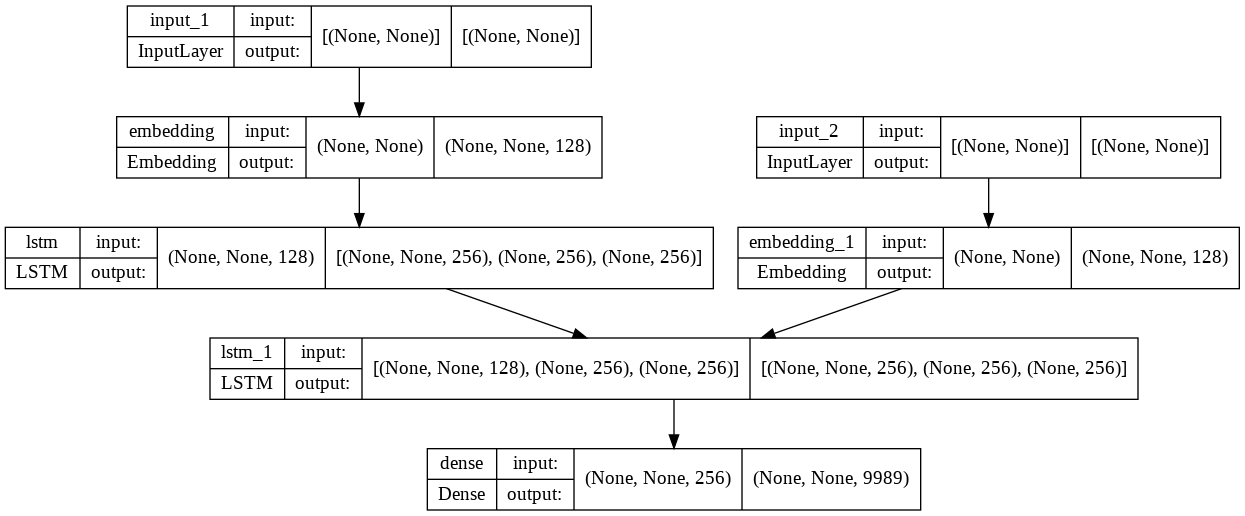

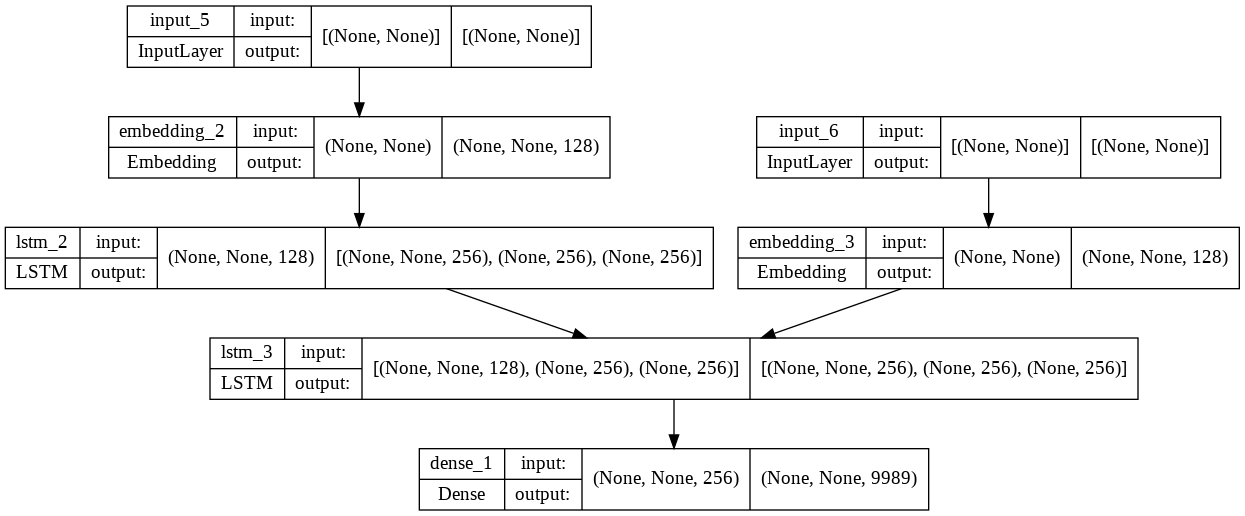

In [87]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [88]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 10s 26ms/step - loss: 1.9461 - val_loss: 1.8469
Epoch 2/50
235/235 [==============================] - 5s 21ms/step - loss: 1.4332 - val_loss: 1.6785
Epoch 3/50
235/235 [==============================] - 5s 22ms/step - loss: 1.2657 - val_loss: 1.5345
Epoch 4/50
235/235 [==============================] - 5s 22ms/step - loss: 1.1574 - val_loss: 1.4483
Epoch 5/50
235/235 [==============================] - 5s 21ms/step - loss: 1.0815 - val_loss: 1.3978
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 1.0248 - val_loss: 1.3730
Epoch 7/50
235/235 [==============================] - 5s 21ms/step - loss: 0.9788 - val_loss: 1.3352
Epoch 8/50
235/235 [==============================] - 5s 22ms/step - loss: 0.9397 - val_loss: 1.3040
Epoch 9/50
235/235 [==============================] - 5s 21ms/step - loss: 0.9059 - val_loss: 1.2784
Epoch 10/50
235/235 [==============================] - 5s 21ms/step - loss: 0.8750 - val_l

Epoch 1/50
235/235 [==============================] - 9s 26ms/step - loss: 1.9573 - val_loss: 1.8460
Epoch 2/50
235/235 [==============================] - 5s 21ms/step - loss: 1.4370 - val_loss: 1.6702
Epoch 3/50
235/235 [==============================] - 5s 21ms/step - loss: 1.2635 - val_loss: 1.5228
Epoch 4/50
235/235 [==============================] - 5s 21ms/step - loss: 1.1544 - val_loss: 1.4595
Epoch 5/50
235/235 [==============================] - 5s 21ms/step - loss: 1.0757 - val_loss: 1.3919
Epoch 6/50
235/235 [==============================] - 5s 21ms/step - loss: 1.0178 - val_loss: 1.3542
Epoch 7/50
235/235 [==============================] - 5s 21ms/step - loss: 0.9728 - val_loss: 1.3248
Epoch 8/50
235/235 [==============================] - 5s 21ms/step - loss: 0.9329 - val_loss: 1.2974
Epoch 9/50
235/235 [==============================] - 5s 21ms/step - loss: 0.8977 - val_loss: 1.2826
Epoch 10/50
235/235 [==============================] - 5s 21ms/step - loss: 0.8668 - val_lo

#Step 6. 모델 평가하기


In [89]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         615680    
                                                                 
 lstm (LSTM)                 [(None, None, 256),       394240    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,009,920
Trainable params: 1,009,920
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(N

In [90]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

In [91]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1278592     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

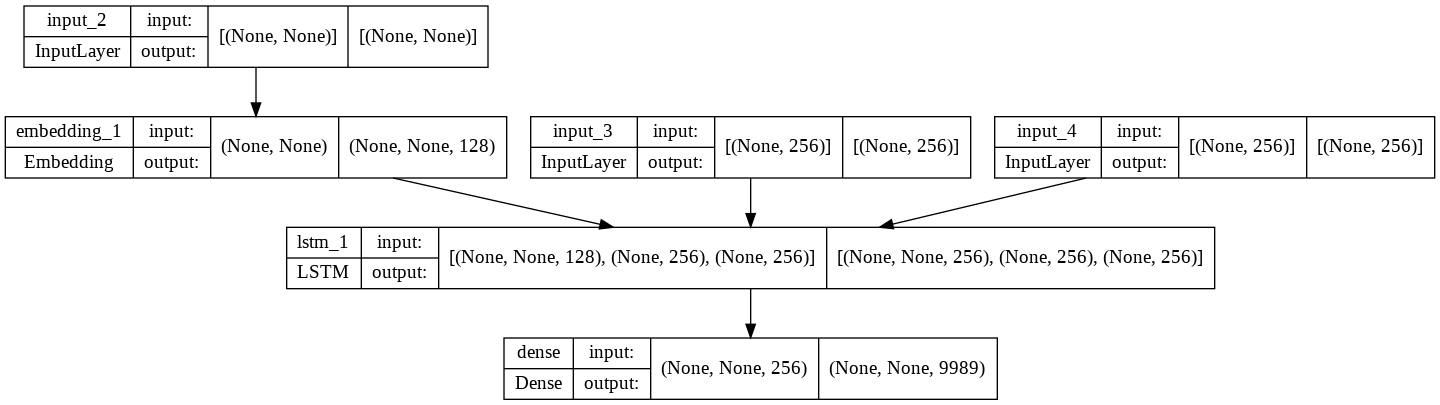

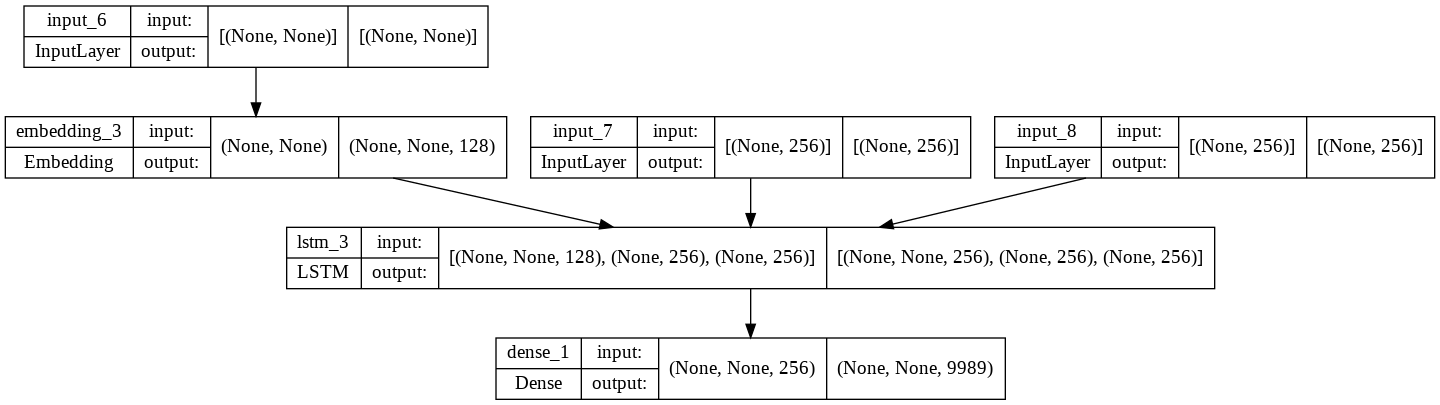

In [92]:
import tensorflow as tf
tf.keras.utils.plot_model(decoder_model, show_shapes=True, show_layer_names=True)

In [93]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [94]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)
  
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = fra_tokenizer.word_index[sos_token[0]]

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
      # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # 예측 결과를 문자로 변환
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = fra_tokenizer.index_word[sampled_token_index]

      # 현재 시점의 예측 문자를 예측 문장에 추가
      decoded_sentence += sampled_char + ' '

      # <eos>에 도달하거나 최대 길이를 넘으면 중단.
      if (sampled_char == eos_token[0] or
          len(decoded_sentence) > max_fra_seq_len):
          stop_condition = True

      # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
      target_seq = np.zeros((1, 1))
      target_seq[0, 0] =  sampled_token_index

      # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
      states_value = [h, c]

  return decoded_sentence

In [95]:
encoder_input

array([[26,  1,  0, ...,  0,  0,  0],
       [26,  1,  0, ...,  0,  0,  0],
       [26,  1,  0, ...,  0,  0,  0],
       ...,
       [41, 34, 29, ...,  0,  0,  0],
       [41, 34, 29, ...,  0,  0,  0],
       [41, 34,  4, ...,  0,  0,  0]], dtype=int32)

array([[26,  1,  0, ...,  0,  0,  0],
       [26,  1,  0, ...,  0,  0,  0],
       [26,  1,  0, ...,  0,  0,  0],
       ...,
       [41, 34, 29, ...,  0,  0,  0],
       [41, 34, 29, ...,  0,  0,  0],
       [41, 34,  4, ...,  0,  0,  0]], dtype=int32)

In [96]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: ['hi', '.']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut ! 

-----------------------------------
입력 문장: ['hello', '!']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut ! 

-----------------------------------
입력 문장: ['hop', 'in', '.']
정답 문장: ['montez', '.']
번역기가 번역한 문장: monte . 

-----------------------------------
입력 문장: ['help', 'me', '!']
정답 문장: ['aide-moi', '!']
번역기가 번역한 문장: aide-moi ! 

-----------------------------------
입력 문장: ['humor', 'tom', '.']
정답 문장: ['mettez', 'tom', 'de', 'bonne', 'humeur', '.']
번역기가 번역한 문장: mets tom de tom
-----------------------------------
입력 문장: ['hi', '.']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut ! 

-----------------------------------
입력 문장: ['hello', '!']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut ! 

-----------------------------------
입력 문장: ['hop', 'in', '.']
정답 문장: ['montez', '.']
번역기가 번역한 문장: attendez . 

-----------------------------------
입력 문장: ['help', 'me', '!']
정답 문장: ['aide-moi', '!']
번역기가 번역한 문장: aide-moi ! 

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
LSTM 모델 세부 구조를 분석하는것이 어려웠다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
데이터 정제, 정규화, 전처리과정에 대해 익숙해졌다

### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.


>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. |구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|
>|2|seq2seq 기반의 번역기 모델이 정상적으로 구동된다.| seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.|
>|3|테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.|


입력 문장: ['hello', '!']
정답 문장: ['salut', '!']
번역기가 번역한 문장: salut ! 
> 한글번역 : 안녕

입력 문장: ['help', 'me', '!']
정답 문장: ['aide-moi', '!']
번역기가 번역한 문장: aide-moi ! 

>한글 번역 :도와줘

입력 문장: ['humor', 'tom', '.']
정답 문장: ['mettez', 'tom', 'de', 'bonne', 'humeur', '.']
번역기가 번역한 문장: mets tom de tom

> 한글 번역 : ???


### - **자기 다짐**
* 코드 복기하기
